In [3]:
from dataclasses import dataclass
from typing import Any
import math
import random
import copy
import numpy as np
import torch
import torch.nn as nn

import seaborn as sns
import matplotlib.pyplot as plt

import src.game.game
import src.game.state
from src.game.game import Game
from src.game.state import GameState, GameStateTorch

import importlib
importlib.reload(src.game.game)
importlib.reload(src.game.state)
# Game = src.game.game.Game
# GameState = src.game.state.GameState
# GameStateTorch = src.game.state.GameStateTorch

<module 'src.game.state' from '/home/khang200923/proj/queen-duel-bot/src/game/state.py'>

In [115]:
class RandomAgent:
    def __init__(self):
        pass

    def play(self, state: GameState) -> np.ndarray:
        return np.ones((8, 8), dtype=np.float32) / 64.0

class SimpleCleverAgent:
    def __init__(self):
        pass

    def play(self, state: GameState) -> np.ndarray:
        hmm = state.mask_legal_moves() * state.oppq_board
        if hmm.sum() > 0.001:
            return hmm
        return np.ones((8, 8), dtype=np.float32) / 64.0

class SmolQAgent(nn.Module):
    def __init__(self, epsilon: float = 0.1):
        super().__init__()
        self.epsilon = epsilon
        self.conv = nn.Sequential(
            nn.Conv2d(4, 24, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(24, 24, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(24, 24, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(24, 24, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(24, 24, kernel_size=5, padding=2),
            nn.ReLU(),
        )
        self.trunk = nn.Sequential(
            nn.Flatten(),
            nn.Linear(24*8*8, 384),
            nn.ReLU(),
            nn.Linear(384, 384),
            nn.ReLU(),
        )
        self.head_value = nn.Linear(384, 1)
        self.head_advantage = nn.Linear(384, 64)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        def core(x):
            x = self.conv(x)
            x = self.trunk(x)
            v = self.head_value(x)
            a = self.head_advantage(x)
            x = v + a - a.mean(dim=1, keepdim=True)
            return x.view(-1, 8, 8)
        x0 = core(x)
        x1 = core(x.flip(dims=[2])).flip(dims=[1])
        x2 = core(x.flip(dims=[3])).flip(dims=[2])
        x3 = core(x.flip(dims=[2, 3])).flip(dims=[1, 2])
        res = (x0 + x1 + x2 + x3) / 4.0
        return res.view(-1, 64)

    def play(self, state: GameState) -> np.ndarray:
        state_torch = state.convert_to_torch()
        with torch.no_grad():
            res = self(state_torch.all_boards().unsqueeze(0)).squeeze(0)
            illegal_mask = 1 - state_torch.legal_moves_mask.flatten()
            res = res - illegal_mask * 100
            best_ind = torch.argmax(res)
            best_action_probs = torch.full_like(res, 0.0)
            best_action_probs.scatter_(0, best_ind.unsqueeze(0), 1.0)
            if self.training:
                if torch.randn(1) < self.epsilon:
                    best_action_probs = torch.ones_like(res) / res.numel()
        return best_action_probs.view(8,8).cpu().numpy()


In [116]:
@dataclass
class ReplayEntry:
    state: GameStateTorch
    action: torch.Tensor # shape (1, ); index on flattened board (0-63 inclusive)
    reward: float
    next_state: GameStateTorch
    done: bool

In [117]:
def empty_game_state_torch() -> GameStateTorch:
    return GameStateTorch(
        blockers_board=torch.zeros((8, 8), dtype=torch.float32),
        selfq_board=torch.zeros((8, 8), dtype=torch.float32),
        oppq_board=torch.zeros((8, 8), dtype=torch.float32),
        legal_moves_mask=torch.ones((8, 8), dtype=torch.float32)
    )

In [118]:
def get_reward(game: Game, side: bool, legal: bool) -> float:
    reward = 0
    if game.result is not None:
        reward = 1 if game.result == side else -1
    reward -= 0.005 if not legal else 0
    reward += game.heuristic_reward()
    return reward * 10

In [119]:
# def loss_nograd_one(agent: nn.Module, target: nn.Module, entry: ReplayEntry) -> float:
#     state = entry.state
#     action = entry.action
#     reward = entry.reward
#     next_state = entry.next_state
#     done = entry.done

#     with torch.no_grad():
#         target_q_values = target(next_state.all_boards().unsqueeze(0)).squeeze(0)
#         target_value = target_q_values.max().item() if not done else 0.0

#     q_values = agent(state.all_boards().unsqueeze(0)).squeeze(0)
#     q_value = q_values[action]

#     loss = (q_value - (reward + target_value)) ** 2
#     return loss.item()

In [120]:
def train_step(agent: nn.Module, target: nn.Module, optimizer: torch.optim.Optimizer, buffer: list[ReplayEntry], GAMMA: float = 0.99) -> float:
    optimizer.zero_grad()
    device = buffer[0].state.selfq_board.device

    states = torch.stack([entry.state.all_boards() for entry in buffer]).to(device)
    actions = torch.stack([entry.action for entry in buffer]).to(device)
    rewards = torch.as_tensor([entry.reward for entry in buffer], dtype=torch.float32, device=device)
    next_states = torch.stack([entry.next_state.all_boards() for entry in buffer]).to(device)
    dones = torch.as_tensor([entry.done for entry in buffer], dtype=torch.float32, device=device)

    q_values = agent(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    with torch.no_grad():
        best_actions = agent(next_states).argmax(1, keepdim=True)
        next_q_values = target(next_states).gather(1, best_actions).squeeze(1)
    target_q_values = rewards + (1 - dones) * next_q_values * GAMMA

    assert q_values.shape == target_q_values.shape, f"q_values shape {q_values.shape} does not match target_q_values shape {target_q_values.shape}"
    loss = nn.functional.mse_loss(q_values, target_q_values)
    loss.backward()
    optimizer.step()

    return loss.item()

In [121]:
def soft_update(target, source, tau):
    for target_param, source_param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(
            tau * source_param.data + (1.0 - tau) * target_param.data
        )

In [122]:
agent = SmolQAgent()
target = copy.deepcopy(agent)
def oppo_choose():
    return random.choice([SimpleCleverAgent(), SimpleCleverAgent(), agent])
optimizer = torch.optim.Adam(agent.parameters(), lr=1.5e-3, betas=(0.9, 0.999))
epoch = 0

In [123]:
buffer: list[ReplayEntry] = []
ENTRIES_PER_TRAIN_STEP = 512
UPDATES_PER_TRAIN_STEP = 12
win_rate_graph = []
reward_graph = []
legal_graph = []
is_white_agent = True

In [124]:
agent.train()
while True:
# for _ in range(1):
    print(f"Epoch {epoch}")
    game = Game(agent, oppo_choose()) if is_white_agent else Game(oppo_choose(), agent)
    reward_list = []
    legal_list = []
    win_list = []
    for _ in range(ENTRIES_PER_TRAIN_STEP * 2):
        if game.result is not None:
            game.white = agent if is_white_agent else oppo_choose()
            game.black = oppo_choose() if is_white_agent else agent
            game.reset()
        if game.is_white_turn != is_white_agent:
            game.agent_move()
            if game.result is not None:
                win_list.append(game.result == is_white_agent)
                is_white_agent = not is_white_agent
            continue
        state = game.get_state().convert_to_torch()
        _, move, legal = game.agent_move()
        reward = get_reward(game, is_white_agent, legal)
        reward_list.append(reward)
        legal_list.append(legal)
        if game.result is not None:
            win_list.append(game.result == is_white_agent)
            # if is_white_agent: win_list.append(game.result)
            is_white_agent = not is_white_agent
        done = game.result is not None
        next_state = game.get_state().convert_to_torch() if not done else empty_game_state_torch()
        entry = ReplayEntry(
            state=state,
            action=torch.tensor(move, dtype=torch.int64, device=state.selfq_board.device),
            reward=reward,
            next_state=next_state,
            done=done,
        )
        # entry.importance = math.sqrt(loss_nograd_one(agent, target, entry))
        buffer.append(entry)
    reward_graph.append(np.mean(reward_list))
    legal_graph.append(len(list(x for x in legal_list if x)) / len(legal_list))
    win_rate_graph.append(len(list(x for x in win_list if x)) / len(win_list))
    print(f"Average reward: {np.mean(reward_list):.4f}, unnoised: {np.mean(reward_graph[-20:])}")
    print(f"Chance of legal move: {len(list(x for x in legal_list if x)) / len(legal_list):.2%}, unnoised: {np.mean(legal_graph[-20:]):.2%}")
    print(f"Win rate: {len(list(x for x in win_list if x)) / len(win_list):.2%}, unnoised: {np.mean(win_rate_graph[-20:]):.2%}")
    print(f"Games played this epoch: {len(win_list)}")
    print("Switching to training mode")

    loss_list = []
    for i in range(UPDATES_PER_TRAIN_STEP):
        sample_buffer = random.sample(buffer, 96)
        loss = train_step(agent, target, optimizer, sample_buffer)
        loss_list.append(loss)
    print(f"Loss: mean={np.mean(loss_list):.4f}, median={np.median(loss_list):.4f}, std={np.std(loss_list):.4f}")
    random.shuffle(buffer)
    del buffer[:int(len(buffer) * 0.02)]
    soft_update(target, agent, tau=0.015)
    epoch += 1
    print()
    print("Switching to playing mode")


Epoch 0
Average reward: 0.3774, unnoised: 0.37736742424242425
Chance of legal move: 100.00%, unnoised: 100.00%
Win rate: 16.16%, unnoised: 16.16%
Games played this epoch: 99
Switching to training mode
Loss: mean=3.6038, median=3.9677, std=2.2139

Switching to playing mode
Epoch 1
Average reward: 0.3651, unnoised: 0.3712347579379452
Chance of legal move: 100.00%, unnoised: 100.00%
Win rate: 24.36%, unnoised: 20.26%
Games played this epoch: 78
Switching to training mode
Loss: mean=2.7877, median=2.5330, std=1.4628

Switching to playing mode
Epoch 2
Average reward: 0.3847, unnoised: 0.37571900529196345
Chance of legal move: 100.00%, unnoised: 100.00%
Win rate: 21.84%, unnoised: 20.79%
Games played this epoch: 87
Switching to training mode
Loss: mean=4.0530, median=4.0822, std=1.2598

Switching to playing mode
Epoch 3
Average reward: 0.2802, unnoised: 0.3518418623359081
Chance of legal move: 100.00%, unnoised: 100.00%
Win rate: 14.61%, unnoised: 19.24%
Games played this epoch: 89
Switching

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f63afb1aa70>>
Traceback (most recent call last):
  File "/home/khang200923/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


Average reward: 0.3232, unnoised: 0.3771132830072004
Chance of legal move: 100.00%, unnoised: 100.00%
Win rate: 17.78%, unnoised: 21.51%
Games played this epoch: 90
Switching to training mode
Loss: mean=2.8174, median=2.7904, std=1.3257

Switching to playing mode
Epoch 24
Average reward: 0.4145, unnoised: 0.37893805182387774
Chance of legal move: 100.00%, unnoised: 100.00%
Win rate: 25.97%, unnoised: 21.76%
Games played this epoch: 77
Switching to training mode
Loss: mean=3.2087, median=3.2218, std=1.5140

Switching to playing mode
Epoch 25


KeyboardInterrupt: 

In [14]:
# base win rate
game = Game(RandomAgent(), SimpleCleverAgent())
wins = 0
for _ in range(10000):
    game.reset()
    while game.result is None:
        game.agent_move()
    wins += 1 if game.result else 0
print(f"Base win rate: {wins / 10000:.2%}")

Base win rate: 5.64%


In [127]:
game = Game(agent, RandomAgent())
wins = 0
for _ in range(200):
    game.reset()
    while game.result is None:
        game.agent_move()
    wins += 1 if game.result else 0
print(f"Win rate: {wins / 200:.2%}")

Win rate: 60.50%


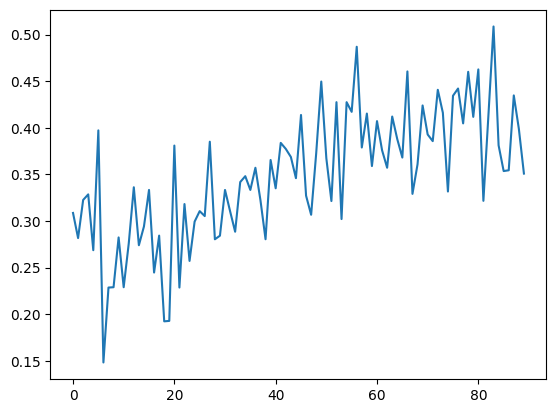

In [109]:
plt.plot(win_rate_graph)
plt.show()

In [37]:
graph_np = np.array(reward_graph)
autocorr = np.corrcoef(graph_np[:-1], graph_np[1:])[0, 1]
print(f"Autocorrelation: {autocorr:.4f}")

Autocorrelation: 0.1476


In [ ]:
def profiled():
    game = Game(oppo, oppo)
    wins = 0
    for _ in range(200):
        game.reset()
        while game.result is None:
            game.agent_move()
        wins += 1 if game.result else 0

%prun -s cumulative -l 10 profiled()

In [55]:
# visual debug test
agent.eval()
game = Game(agent, oppo_choose())
game.reset()
while game.result is None:
    print(game.repr_board())
    print()
    game.agent_move()
print(game.repr_board())
print(f"result {game.result}")

. . . . W . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . B . . . .

. . . . █ . W .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . B . . . .

. . . . █ . W .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. B . █ . . . .

. . . . █ . █ .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. B . █ . . W .

. B . . █ . █ .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. █ . █ . . W .

. B . . █ . █ .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . W . . .
. . . . . . . .
. █ . █ . . █ .

. █ . . █ . █ .
. . . . . . . .
. . . B . . . .
. . . . . . . .
. . . . . . . .
. . . . W . . .
. . . . . . . .
. █ . █ . . █ .

. █ . . █ . █ .
. . . . . . . .
. . . B W . . .
. . . . . . . .
. . . . . . . .
. . . . █ . . .
.

In [ ]:
len(list(x for x in win_rate_graph if x > 0.5)) / len(win_rate_graph)

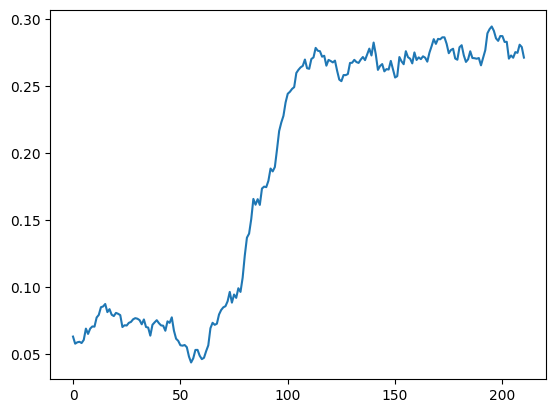

In [359]:
window = 10
smoothed = np.convolve(win_rate_graph, np.ones(window)/window, mode='valid')
plt.plot(smoothed)
plt.show()

█ █ . . █ . . .
█ . B . . . . .
. W . . . . . .
. . . . . . . .
. . . █ . . . .
. . . . . . . .
█ █ . █ . . . .
. . █ █ . . . .


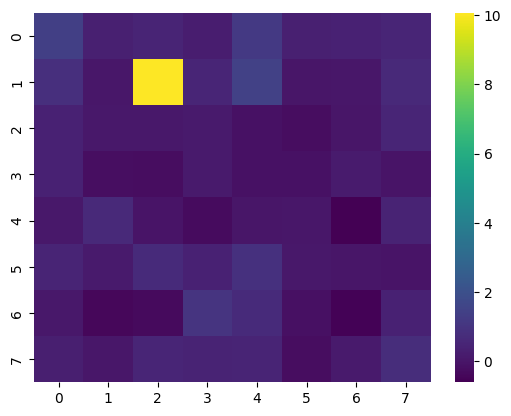

In [27]:
game = Game(RandomAgent(), RandomAgent())
game.reset()
for _ in range(10):
    game.agent_move()
    if game.result is not None:
        break
# agent.head_advantage(agent.conv(game.get_state().convert_to_torch().all_boards().unsqueeze(0))).squeeze(0).reshape((8, 8))
# agent.head_value(agent.conv(game.get_state().convert_to_torch().all_boards().unsqueeze(0))).squeeze(0)
if game.result is None:
    data = agent(game.get_state().convert_to_torch().all_boards().unsqueeze(0))
    print(game.repr_board())
    sns.heatmap(data.view(8,8).detach().numpy(), cmap="viridis")

In [ ]:
game.get_state().convert_to_torch().all_boards()

In [263]:
def core(x, self):
    x = self.conv(x)
    x = self.trunk(x)
    v = self.head_value(x)
    a = self.head_advantage(x)
    x = v + a - a.mean(dim=1, keepdim=True)
    return x.view(-1, 8, 8)

<Axes: >

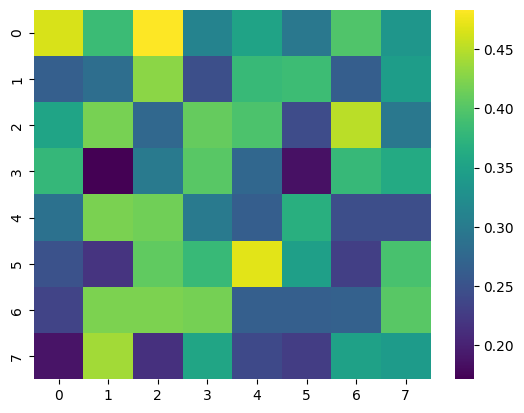

In [289]:
dd0 = core(game.get_state().convert_to_torch().all_boards().unsqueeze(0), agent)
# dd0 = core(game.get_state().convert_to_torch().all_boards().unsqueeze(0).flip(), agent)
# sns.heatmap(dd.view(8,8).detach().numpy(), cmap="viridis")
sns.heatmap(dd0.view(8,8).detach().numpy(), cmap="viridis")

<Axes: >

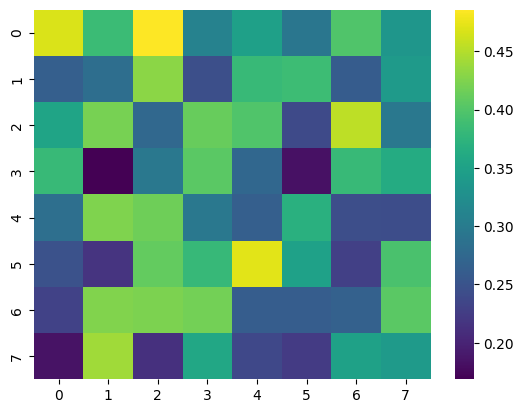

In [290]:
sns.heatmap(data.view(8,8).detach().numpy(), cmap="viridis")